In [1]:
from printrun.printcore import printcore
from printrun import gcoder
import time
import pyvisa
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Connect to Devices

##### Scope

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x1AB1::0x044D::DHO8A254404063::INSTR')
print(f'Scope: {scope.query('*IDN?')}')

Scope: RIGOL TECHNOLOGIES,DHO804,DHO8A254404063,00.01.01



##### 3D Printer

In [30]:
# Connect to printer
p = printcore("COM3", 115200)

## Set Up

##### Scope

In [52]:
# General Scope Setup
scope.write(":TIM:SCAL 0.00002")  # Set timebase to 1000 us/div

19

In [ ]:
# Transmitter
scope.write(":CHAN1:OFFS 0")
scope.write(":CHAN1:SCAL 3.5")    # Set CH1 voltage scale to 3.5V/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
scope.write(":TRIG:LEV 5.2")    # Set trigger level to 0.5V

15

In [5]:
# Receiver
scope.write(":CHAN2:OFFS 0")
scope.write(":CHAN2:SCAL 0.02")    # Set CH1 voltage scale to 20mV/div
scope.write(":ACQ:TYPE AVER")
scope.write(":ACQ:AVER 4")
#scope.write(":TRIG:LEV ")    # Set trigger level to 0.5V

13

##### 3D Printer

In [31]:
p.send("G91")

In [7]:
p.send("G28")

In [39]:
p.send("G28 X0 Y0") # Home only X and Y

In [40]:
p.send("G28 Z0") # Home only Z

In [41]:
p.send("G1 Z440 F12000") # Move Z down to bottom

In [42]:
p.send("G1 X150 Y100 F12000") # Center X and Y

In [44]:
p.send("G1 Y2.5 F1000")

In [49]:
p.send("G1 Z-20 F12000")

## Measurement Function

In [53]:
def measure_scope_vpp():
    measurements = np.array([float(scope.query(":MEAS:VPP? CHAN2")) for _ in range(10)])
    meas_avg = np.average(sorted(measurements)[5:])
    return meas_avg

In [54]:
print(measure_scope_vpp())

0.021044600000000004


## 3D Printer Movement and Data Acquisition

In [98]:
p.send("G1 X1 F1000")

In [91]:
p.send("G1 Y1 F1000")

In [ ]:
# Find peak (center)
p.send("G1 X-5 Y-5 F1000")
(x_max, y_max) = (0,0)
max_measure = 0
for i in tqdm(range(10)):
    for j in tqdm(range(10)):
        measurement = measure_scope_vpp()
        if measurement > max_measure:
            max_measure = measurement
            x_max = j
            y_max = i
        p.send("G1 X1 F1000")
        time.sleep(0.5)
    p.send("G1 X-10 Y1 F1000")
    time.sleep(3)
p.send("G1 Y-10 F1000")
time.sleep(5)
p.send(f"G1 X{x_max} Y{y_max} F1000")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
p.send("G1 Z-50 F12000")

In [ ]:
z_planes = 1
y_points = 50
x_points = 50
x_range = 50 # mm
y_range = 50 # mm
x_movement = x_range / x_points 
y_movement = y_range / y_points
measurements = np.zeros((z_planes, y_points, x_points))
p.send(f'G1 X-{x_range/2} Y-{y_range/2} F1000')
time.sleep(5)
for i in tqdm(range(z_planes)): # Z
    for j in tqdm(range(y_points)): # Y 
        for k in tqdm(range(x_points)): # X
            # Measure here
            measurements[i,j,k] = measure_scope_vpp()
            p.send(f"G1 X{x_movement} F1000")
            time.sleep(0.15)
        # Measure last x point 
        p.send(f"G1 X-{x_range} Y{y_movement} F1000")
        time.sleep(3)
    # p.send(f"G1 Y-{y_range} Z10 F3000")
    time.sleep(5)
# p.send(f'G1 X{x_range/2} Y{y_range/2} Z{z_planes * 10} F12000')
# p.send(f'G1 X-{x_range/2} Y-{y_range/2} F12000')
print(measurements)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[[[0.00769602 0.00634134 0.00737336 0.00934134 0.0109654  0.0125628
   0.0106722  0.0123414  0.0147784  0.0151122  0.0167358  0.0194428
   0.0210826  0.018376   0.0165494  0.0131386  0.0128108  0.0141572
   0.0132452  0.01060814]
  [0.0152828  0.00896266 0.0114588  0.013648   0.0163574  0.018488
   0.0154826  0.0199682  0.0226454  0.0216534  0.0204934  0.019184
   0.01904    0.0214158  0.0233176  0.0218     0.0187656  0.0172054
   0.0146558  0.0122586 ]
  [0.0170668  0.0106482  0.0143228  0.0168932  0.0192238  0.0185864
   0.0235092  0.029448   0.0309812  0.029792   0.0264376  0.0240694
   0.020784   0.021069   0.021709   0.0249466  0.0238054  0.0197522
   0.019896   0.0155042 ]
  [0.0159626  0.0120454  0.015448   0.01584    0.0213652  0.0267122
   0.0331892  0.034939   0.0332162  0.0296746  0.0268374  0.02804
   0.0277362  0.0231092  0.0204958  0.0272426  0.0311788  0.0282748
   0.020648   0.0147708 ]
  [0.0223144  0.0136826  0.0142616  0.0214078  0.0318346  0.0361254
   0.0366986  0.

In [103]:
p.send(f'G1 X{x_range/2} Y-{y_range/2} F1000')

In [102]:
p.send("G1 Y10 F1000")

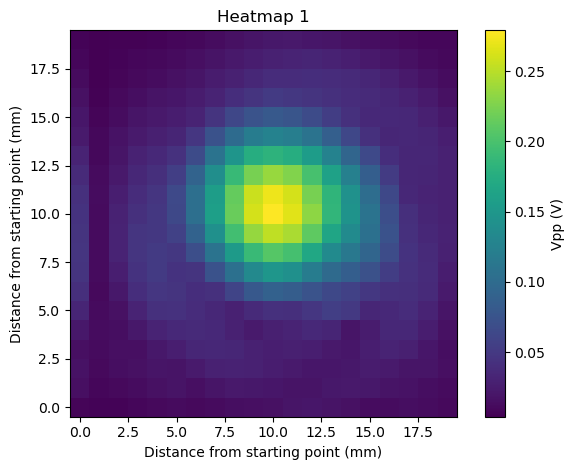

In [100]:
# Plot and save
img1 = plt.imshow(measurements[0], cmap="viridis", interpolation="nearest", origin="lower")
plt.title("Heatmap 1")
plt.xlabel("Distance from starting point (mm)")
plt.ylabel("Distance from starting point (mm)")

# Add colorbars
plt.colorbar(img1, label="Vpp (V)")

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Save data
np.savetxt("./images/4_16_25_base_3mm.csv", measurements[0], delimiter=",", fmt="%.2f")  # fmt controls number formatting

In [73]:
p.send("G1 Y5 F1000")

In [81]:
p.send("G1 Z-10 F12000")